# PART 0: OMG check out this incredible TREND!!!! You won't believe your eyes

# PART 0.0 : Cleaning the dataframes and normalising them

In [3]:
#import usefull libraries
import re
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
from pylab import *
import pandas as pd
from dogues_functions_2 import clean_article_name, plot_category_trends, fetch_pageview_count, normal_data, extract_clean_text, fetch_and_combine_pageview_data, scrape_wikipedia_sub_subheadings_with_links, fetch_pageview_count_dates, fetch_viewcount_df


In [98]:
#import data

DATA_FOLDER = 'Data/'

INTERVENTIONS_DATASET = DATA_FOLDER+"interventions.csv"
TOPICS_LINKED_DATASET = DATA_FOLDER+"topics_linked.csv"
GLOBAL_MOBILITY_DATASET = DATA_FOLDER+"Global_Mobility_Report.csv"
APPLE_MOBILITY_DATASET = DATA_FOLDER+"applemobilitytrends-2020-04-20.csv"
TIMESERIES_DATASET = DATA_FOLDER+"aggregated_timeseries.json.gz"

### Downloading Mobility Data to get lockdown dates

In [105]:

from datetime import datetime
def intervention_date(intervention_data, intervention_event):
    year  = int(intervention_data[intervention_event][0:4])
    month = int(intervention_data[intervention_event][5:7])
    day   = int(intervention_data[intervention_event][8:10])
    date  = datetime(year, month, day)
    return date

interventions = pd.read_csv(source+"interventions.csv")
interventions_en= interventions.iloc[12]
#beggining of lockdown 2020-03-16
treatment_start_date = intervention_date(interventions_en, "Mobility") #
 # Back to normal 2020-05-21
treatment_end_date = intervention_date(interventions_en, "Normalcy")


### Import wikipedia sum of english article for period 01-01-2020 to 30-06-2020 ***

In [9]:
agg = pd.read_json(TIMESERIES_DATASET, compression='gzip')
second_row = agg[['en']].iloc[1]
df = pd.DataFrame(second_row)
dic = df['sum'].iloc[0]

# Transform dic into a DataFrame
df = pd.DataFrame.from_dict(dic, orient='index', columns=['sum'])
df.reset_index(inplace=True)
df.columns = ['date', 'sum']

# Transform the date column to datetime
df['date'] = pd.to_datetime(df['date'])

#period between 2020-01-01 and 2020-06-30
df_wiki_size = df.iloc[730:]
df_wiki_size = df_wiki_size.iloc[:-31,:]
df_wiki_size.reset_index(drop=True, inplace=True)

#normalize the wiki data with respect to the mean
mean_wiki = df_wiki_size['sum'].mean()
normw = ((df_wiki_size['sum'] - mean_wiki) / mean_wiki)
df_wiki_norm = df_wiki_size.copy()
df_wiki_norm['sum'] = normw
df_wiki_norm.rename(columns={'sum': 'norm'}, inplace=True)
df_wiki_norm['date'] = pd.to_datetime(df_wiki_size['date'])
df_wiki_norm = df_wiki_norm.iloc[:, :].reset_index(drop=True)




### Import wikipedia fake news articles and get the view count for each article

In [15]:
excel_file_path = 'Data/realFakeNewsNotLikeVictorsRealShy2.xlsx'

# Correspond to around 320 articles
new_res = pd.read_excel(excel_file_path)

#rename column
new_res.rename(columns={'name': 'Linked_Article'}, inplace=True)

new_res = new_res.drop_duplicates()
new_res.reset_index()

#remove the date for the articles that have a date next to the title
new_res.Linked_Article= new_res.Linked_Article.apply(clean_article_name)
#idea of the type of articles

#Fetch the view count for all available articles
language = "en"
combined_df = fetch_and_combine_pageview_data(language, new_res)

Error fetching data for Global_catastrophe_scenarios. Status Code: 404
Error fetching data for Urban_legends_and_myths. Status Code: 404
Error fetching data for Machiavellianism_. Status Code: 404
Error fetching data for Modern_flat_Earth_beliefs. Status Code: 404
Error fetching data for Lake_Michigan_Triangle. Status Code: 404
Error fetching data for Die_Glocke_. Status Code: 404
Error fetching data for Dundy_County_UFO_hoax. Status Code: 404
Error fetching data for Twin_Falls_saucer_hoax. Status Code: 404
Error fetching data for Aztec,_New_Mexico_crashed_saucer_hoax. Status Code: 404
Error fetching data for Alien_Autopsy_. Status Code: 404
Error fetching data for Killing_of_Johnny_Stompanato. Status Code: 404
Error fetching data for Conspiracy_theories_about_the_kidnapping_and_murder_of_Aldo_Moro. Status Code: 404
Error fetching data for Conspiracy_theories_about_the_death_of_Diana,_Princess_of_Wales. Status Code: 404
Error fetching data for Alejandro_Castro_. Status Code: 404
Error 

Aggregate the dataset by categories to plot later on

In [121]:
#Create with article name and the view count in function of the date

combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
df_pivoted = combined_df.pivot_table(index='article', columns='timestamp', values='views', aggfunc='mean')

df_pivoted.reset_index(inplace=True)

#merge the data with the article with the corresponding ciews
merged_df = new_res.merge(df_pivoted, left_on='Linked_Article', right_on='article')
merged_df.drop(['subCategory','article' ],axis = 1, inplace=True)

#fill na with 0 
merged_df.fillna(0, inplace=True)

row_sums = merged_df.iloc[:, 2:].sum(axis=1)

# Add the row sums as a new column to the DataFrame 
merged_df['Row_Sums'] = row_sums

Final_consp_sorted = merged_df.sort_values(by='Row_Sums', ascending=False)
#Drop category overview wich is not very relevant
df_without_overview = Final_consp_sorted[Final_consp_sorted['mainCategory'] != 'Overview']


#aggregate data and categories and drop Linked articles
aggregated_data = df_without_overview.groupby('mainCategory').sum()
aggregated_data.drop('Linked_Article',axis=1, inplace=True)


# Sum values along rows (axis=1)
row_sums = aggregated_data.sum(axis=1)

# Identify the index of the 'Health' category
health_category_index = aggregated_data.index.get_loc('Health')

#Create with article name and the view count in function of the date

df_pivoted = combined_df.pivot_table(index='article', columns='timestamp', values='views', aggfunc='mean')

df_pivoted.reset_index(inplace=True)

#merge the data with the article with the corresponding ciews
merged_df = new_res.merge(df_pivoted, left_on='Linked_Article', right_on='article')
merged_df.drop(['subCategory','article' ],axis = 1, inplace=True)

#fill na with 0 
merged_df.fillna(0, inplace=True)

row_sums = merged_df.iloc[:, 2:].sum(axis=1)

# Add the row sums as a new column to the DataFrame 
merged_df['Row_Sums'] = row_sums

Final_consp_sorted = merged_df.sort_values(by='Row_Sums', ascending=False)
#Drop category overview wich is not very relevant
df_without_overview = Final_consp_sorted[Final_consp_sorted['mainCategory'] != 'Overview']


#for this need to drop the article name and the main category
df_med = df_without_overview.drop(['Linked_Article', 'mainCategory'], axis=1)
agg_data_median = df_med.median()
df_fake = agg_data_median.reset_index()
df_fake.columns = ['date', 'sum']
df_fake = df_fake.iloc[:-1]
df_fake['date'] = pd.to_datetime(df_fake['date'])
df_fake_size = df_fake.copy()

#normalize the fake data with respect to the mean

mean_fake = df_fake_size['sum'].mean()
normf= ((df_fake_size['sum']- mean_fake)/ mean_fake)
df_fake_norm = df_fake_size.copy()
df_fake_norm['sum'] = normf
df_fake_norm.rename(columns={'sum': 'norm'}, inplace=True)


# PART 0.1  Did the interest in fake news increase more than the global increase in wikipedia views!?

For this part we contructed the difference between the normalized increased in wikipedia views and the fake news increase in views.
Using the median article of fake news for each time period then dividing each obtained value by the sum of all the values during the period of interest.

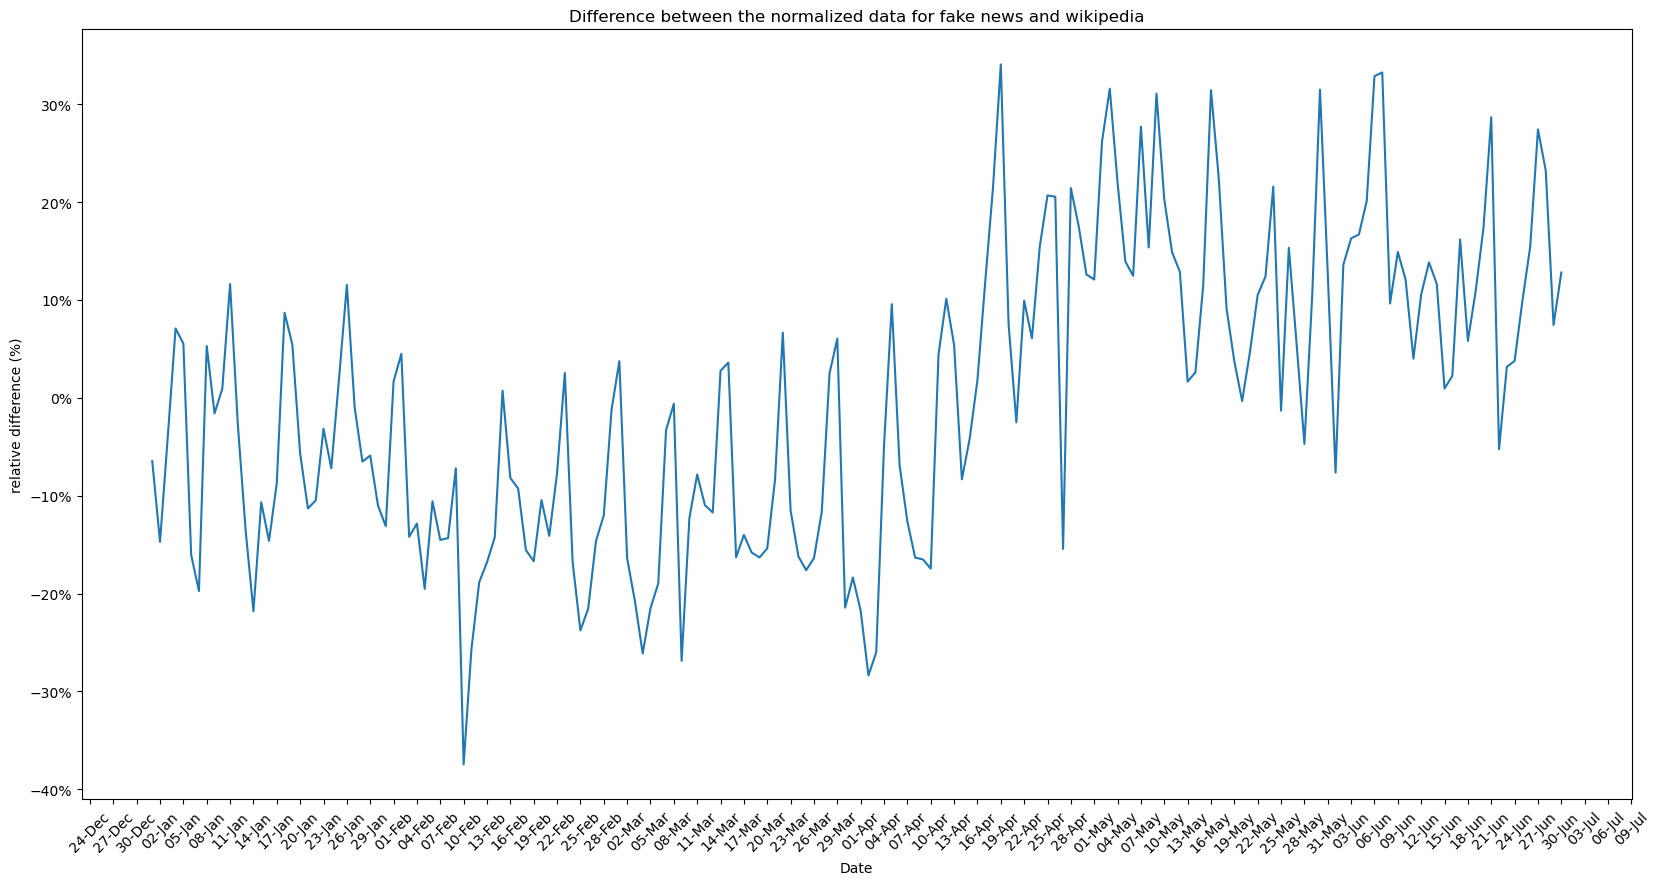

In [101]:
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

df_diff = pd.DataFrame({'date': df_fake_norm['date'], 'sum_diff': df_fake_norm['norm'] - df_wiki_norm['norm']})


plt.figure(figsize=(20,10))
plt.plot(df_diff['date'], df_diff['sum_diff'])
plt.title('Difference between the normalized data for fake news and wikipedia')
plt.xlabel('Date')
plt.ylabel('relative difference (%)')  # Modify the y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set the x-axis tick interval to show every 7 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  # Format the x-axis tick labels to show day and month
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Set the y-axis tick labels as percentages
plt.show()



### Let's do a moving average to smooth our data it has a lot of peaks

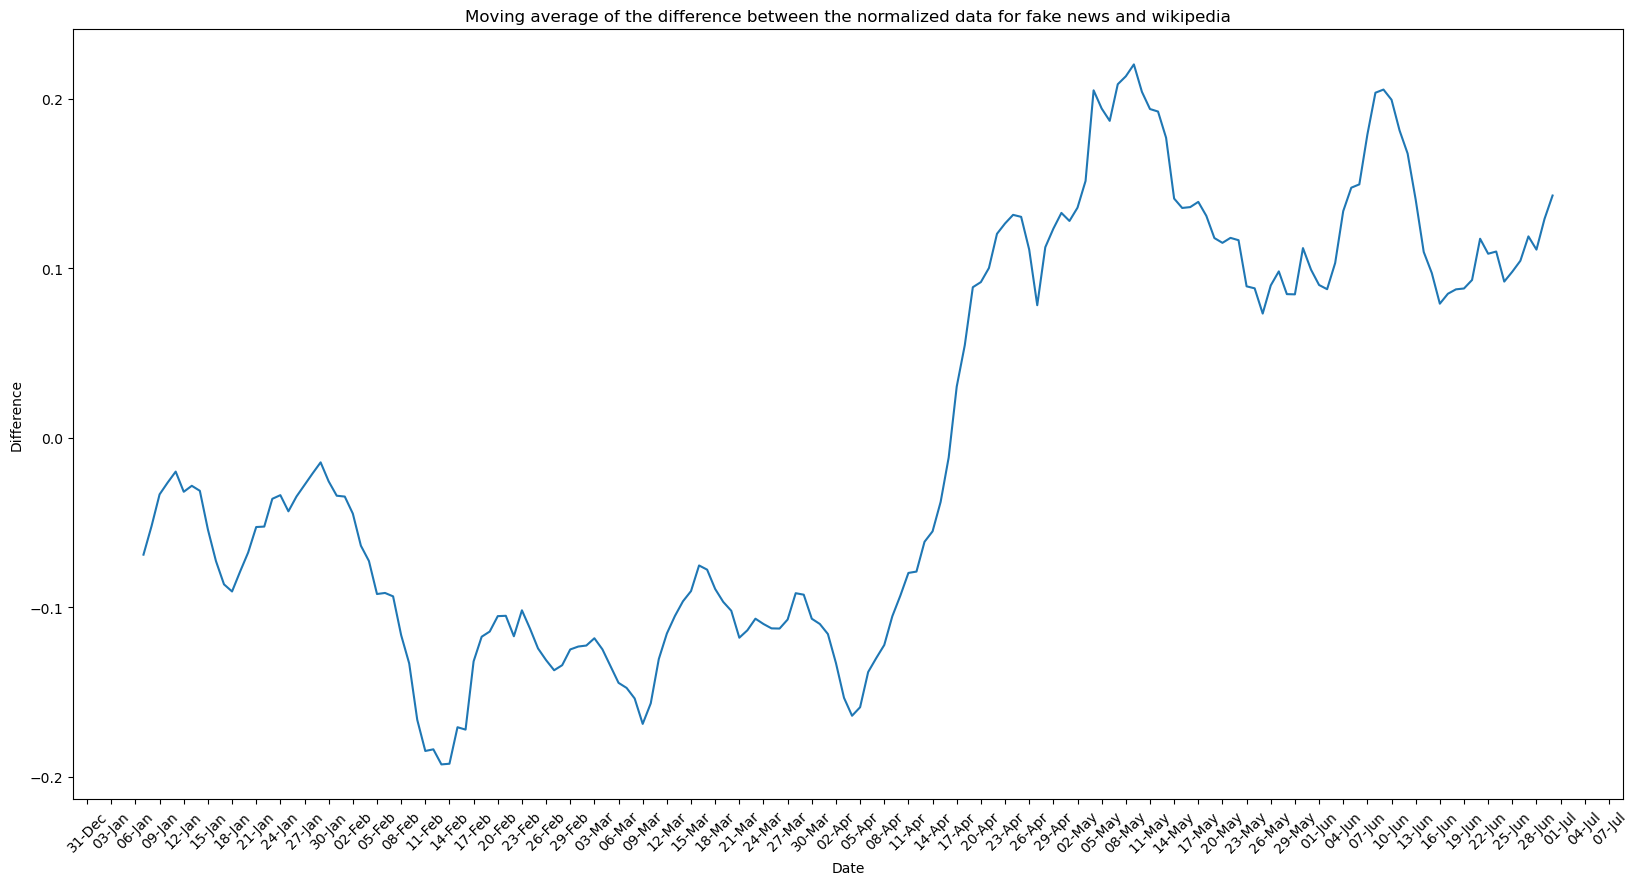

In [103]:
window_size = 7  # Define the window size for the moving average
df_diff['moving_average'] = df_diff['sum_diff'].rolling(window=window_size).mean()
#plot the moving average
plt.figure(figsize=(20,10))
plt.plot(df_diff['date'], df_diff['moving_average'])
plt.title('Moving average of the difference between the normalized data for fake news and wikipedia')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set the x-axis tick interval to show every 7 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  # Format the x-axis tick labels to show day and month
plt.show()

### Let's do the difference and difference method to see if their is a statistical difference in the relative increase in fake news interest.

To check that we do a D & D analysis. It consists in creating a control group consisting of the normalized views 65 days before the lock down and the tretment group with the normalized increase 65 days during the lockdown.

In [109]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas import Timedelta 


# Filter data for 65 days before and after March 14, 2020
start_date = treatment_start_date - pd.Timedelta(days=65)
#treatment_start_date = #beggining of lockdown 2020-03-16
#treatment_end_date = # Back to normal 2020-05-21

# control group data
df_control = df_diff[(df_diff['date'] <= treatment_start_date) & (df_diff['date'] >= start_date)]
df_control.reset_index(drop=True, inplace=True)

# treatment group data
df_treatment = df_diff[(df_diff['date'] >= treatment_start_date) & (df_diff['date'] <= treatment_end_date)]
df_treatment.reset_index(drop=True, inplace=True)

# Add treatment and post-treatment columns
df_treatment['treatment'] = 1
df_control ['treatment'] = 0

df_concatenated = pd.concat([df_control, df_treatment], ignore_index=True)

# Fit the model
model = smf.ols(formula='sum_diff ~ treatment', data=df_concatenated).fit()

# Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               sum_diff   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     30.46
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           1.75e-07
Time:                        16:38:58   Log-Likelihood:                 79.083
No. Observations:                 133   AIC:                            -154.2
Df Residuals:                     131   BIC:                            -148.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1001      0.017     -6.044      0.0

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4856\3509948567.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treatment['treatment'] = 1
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4856\3509948567.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control ['treatment'] = 0


### R-squared = 0.189 and p-value < 0.05 ! 
### So there is an increase interest in fake news during the Covid

Let's plot a box plot to visualize our results.

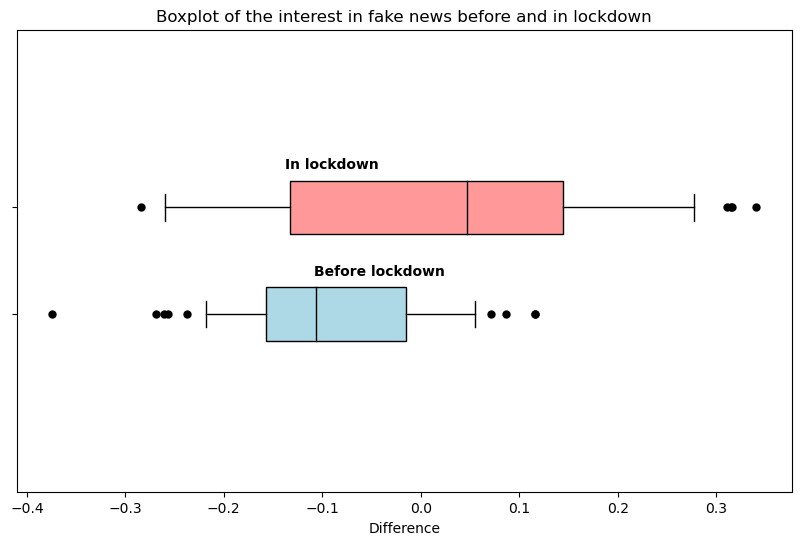

In [108]:
# Combine the control and treatment dataframes
df_combined = pd.concat([df_control, df_treatment])

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the boxplots with smaller vertical distance
boxprops = dict(facecolor='black', color='black', edgecolor='black')  # Added edgecolor to set the border color
whiskerprops = dict(color='black')  # Changed whisker color to red
capprops = dict(color='black')  # Changed cap color to red
flierprops = dict(marker='o', markerfacecolor='black', markersize=5, markeredgecolor='black')  # Added markeredgecolor for fliers
medianprops = dict(color='black')

# Specify the positions of the boxes along the y-axis
positions = [0, 0.3]

bp = ax.boxplot([df_control['sum_diff'], df_treatment['sum_diff']], 
                vert=False, patch_artist=True, 
                boxprops=boxprops, whiskerprops=whiskerprops, 
                capprops=capprops, flierprops=flierprops, 
                medianprops=medianprops, whis=0.5,
                positions=positions)  # Adjust the positions parameter here

# Set the y-axis ticks and labels
ax.set_yticks(positions)
ax.set_yticklabels([])  # Remove y-axis labels

# Set the title and labels
ax.set_title('Boxplot of the interest in fake news before and in lockdown')
ax.set_xlabel('Difference')

# Set the colors of the boxplots
colors = ['lightblue', '#FF9999']  # Replace 'lightred' with '#FF9999' for light red color
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)


# Add labels above the boxplots
ax.text(-0.042, 0.12, 'Before lockdown', ha='center', va='center', color='black', fontweight='bold')
ax.text(-0.09, 0.42, 'In lockdown', ha='center', va='center', color='black', fontweight='bold')

# Show the plot
plt.show()

### We clearly see an increase in the median value however the box plot interquatile range is quite spread out.

# Part 0.2 : Categories of fake news increased during the lockdown

#So we plot pie charts showing the proportion of all news categories before, during and after the lockdown

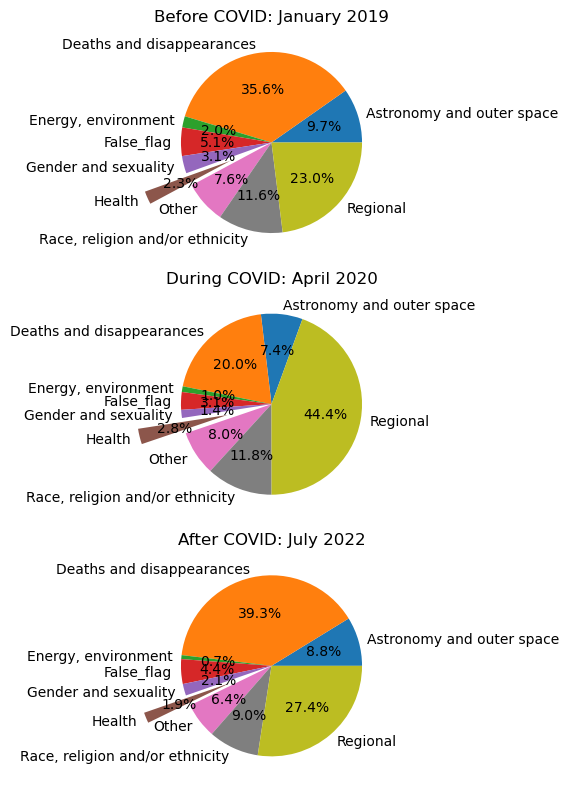

In [129]:
plt.figure(figsize=(20, 8))

# Plot 1st pie chart
plt.subplot(3, 1, 1)
explode = [0.5 if i == health_category_index else 0 for i in range(len(aggregated_data))]
plt.pie(aggregated_data.iloc[:, 1], labels=aggregated_data.index, autopct='%1.1f%%', startangle=0, explode=explode, labeldistance=1.1)
plt.title('Before COVID: January 2019')

# Plot 2nd pie chart
plt.subplot(3, 1, 2)
explode = [0.5 if i == health_category_index else 0 for i in range(len(aggregated_data))]
plt.pie(aggregated_data.iloc[:, 90], labels=aggregated_data.index, autopct='%1.1f%%', startangle=70, explode=explode, labeldistance=1.1)
plt.title('During COVID: April 2020')

# Plot 3rd pie chart
plt.subplot(3, 1, 3)
explode = [0.5 if i == health_category_index else 0 for i in range(len(aggregated_data))]
plt.pie(aggregated_data.iloc[:, 150], labels=aggregated_data.index, autopct='%1.1f%%', startangle=0, explode=explode, labeldistance=1.1)
plt.title('After COVID: July 2022')

plt.tight_layout()
plt.show()

### There is a visible increase in health related fake news this might be because of the increase in fake news related to Covid.
However a lot of wikipedia pages linked to Covid fake news didn't exist add the time we need another database to go more in depth.


# Part 0.3 : How much did the Covid related fake news increased during the lockdown.

### The following database regroups all the pertinent links related to pages related with Covid fake news. An increase in the views of this pages would represent an increase interest in Covid fake news.

The following codes download and cleans the database. Then normalize it and plots the relative increase in Covid fake news interest.



In [73]:
source  = "Data/"
wiki_pages_links = pd.read_csv(source+"covid-19_misinformation5.csv").copy()
language = "en"
articles_list = ["Covid-19"]
result=fetch_pageview_count(language, articles_list)


import ast
wiki_pages_links = pd.read_csv(source+"covid-19_misinformation5.csv").copy()

#Filtering misinformation with the selected clusters
word_cluster_1= "Virus origin" 
word_cluster_2= "Disease spread"
word_cluster_3= "Prevention and treatment"
word_cluster_4= "Mortality"
word_cluster_5= "Other"

wiki_cluster_links_1 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_1))].copy()
wiki_cluster_links_2 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_2))].copy()
wiki_cluster_links_3 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_3))].copy()
wiki_cluster_links_4 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_4))].copy()
wiki_cluster_links_5 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_5))].copy()

# Cleaning the clusters to only obtain words searcheable in wikipedia API
def extract_clean_text(links):
    cleaned_links = []
    for link in links:
        if '/wiki/' in link:
            extracted_text = link.split('/wiki/')[1].split('#')[0].replace('_', ' ')
            cleaned_links.append(extracted_text)
    return cleaned_links

# Convert string representation of list to actual list using ast.literal_eval and apply the function

wiki_cluster_links_1["Cleaned_Text"] = wiki_cluster_links_1["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_2["Cleaned_Text"] = wiki_cluster_links_2["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_3["Cleaned_Text"] = wiki_cluster_links_3["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_4["Cleaned_Text"] = wiki_cluster_links_4["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_5["Cleaned_Text"] = wiki_cluster_links_5["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))

# Looking for all the articles in the cluster 1 which correspond to Virus Origin 

list_cluster_1 = list(wiki_cluster_links_1["Cleaned_Text"])
list_cluster_2 = list(wiki_cluster_links_2["Cleaned_Text"])
list_cluster_3 = list(wiki_cluster_links_3["Cleaned_Text"])
list_cluster_4 = list(wiki_cluster_links_4["Cleaned_Text"])
list_cluster_5 = list(wiki_cluster_links_5["Cleaned_Text"])
language      = "en"
final_count_1 =[]
for i in list_cluster_1:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_1.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 2 which correspond to Spread

list_cluster_2 = list(wiki_cluster_links_2["Cleaned_Text"])
del list_cluster_2[7] # Outlier - this element has an empty list that doesn't allow to concatenate the data frame
final_count_2 =[]
for i in list_cluster_2:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_2.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 3 which correspond to Prevention and Treatment
list_cluster_3 = list(wiki_cluster_links_3["Cleaned_Text"])
final_count_3 =[]
for i in list_cluster_3:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_3.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 4 which correspond to Mortality
list_cluster_4 = list(wiki_cluster_links_4["Cleaned_Text"])
final_count_4 =[]
for i in list_cluster_4:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_4.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 5 which correspond to Other
list_cluster_5 = list(wiki_cluster_links_5["Cleaned_Text"])
final_count_5 =[]
for i in list_cluster_5:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_5.append(pd.DataFrame(merged_df))







Error fetching data for COVID-19 lab leak theory. Status Code: 404
Error fetching data for Li-Meng Yan. Status Code: 404
Error fetching data for Gain-of-function research. Status Code: 404
Error fetching data for Ralph Baric. Status Code: 404
Error fetching data for Chimeric virus. Status Code: 404
Error fetching data for COVID-19 misinformation by China. Status Code: 404
Error fetching data for 2022 Russian invasion of Ukraine. Status Code: 404
Error fetching data for 2022 German coup d%27%C3%A9tat plot. Status Code: 404
Error fetching data for Anti-vaccine activism. Status Code: 404
Error fetching data for Mark Steele (conspiracy theorist). Status Code: 404
Error fetching data for Kate Shemirani. Status Code: 404
Error fetching data for Lidia Morawska. Status Code: 404
Error fetching data for 5G misinformation. Status Code: 404
Error fetching data for Logically (company). Status Code: 404


### Plotting the relative increase of Covid-19 fake news related article.

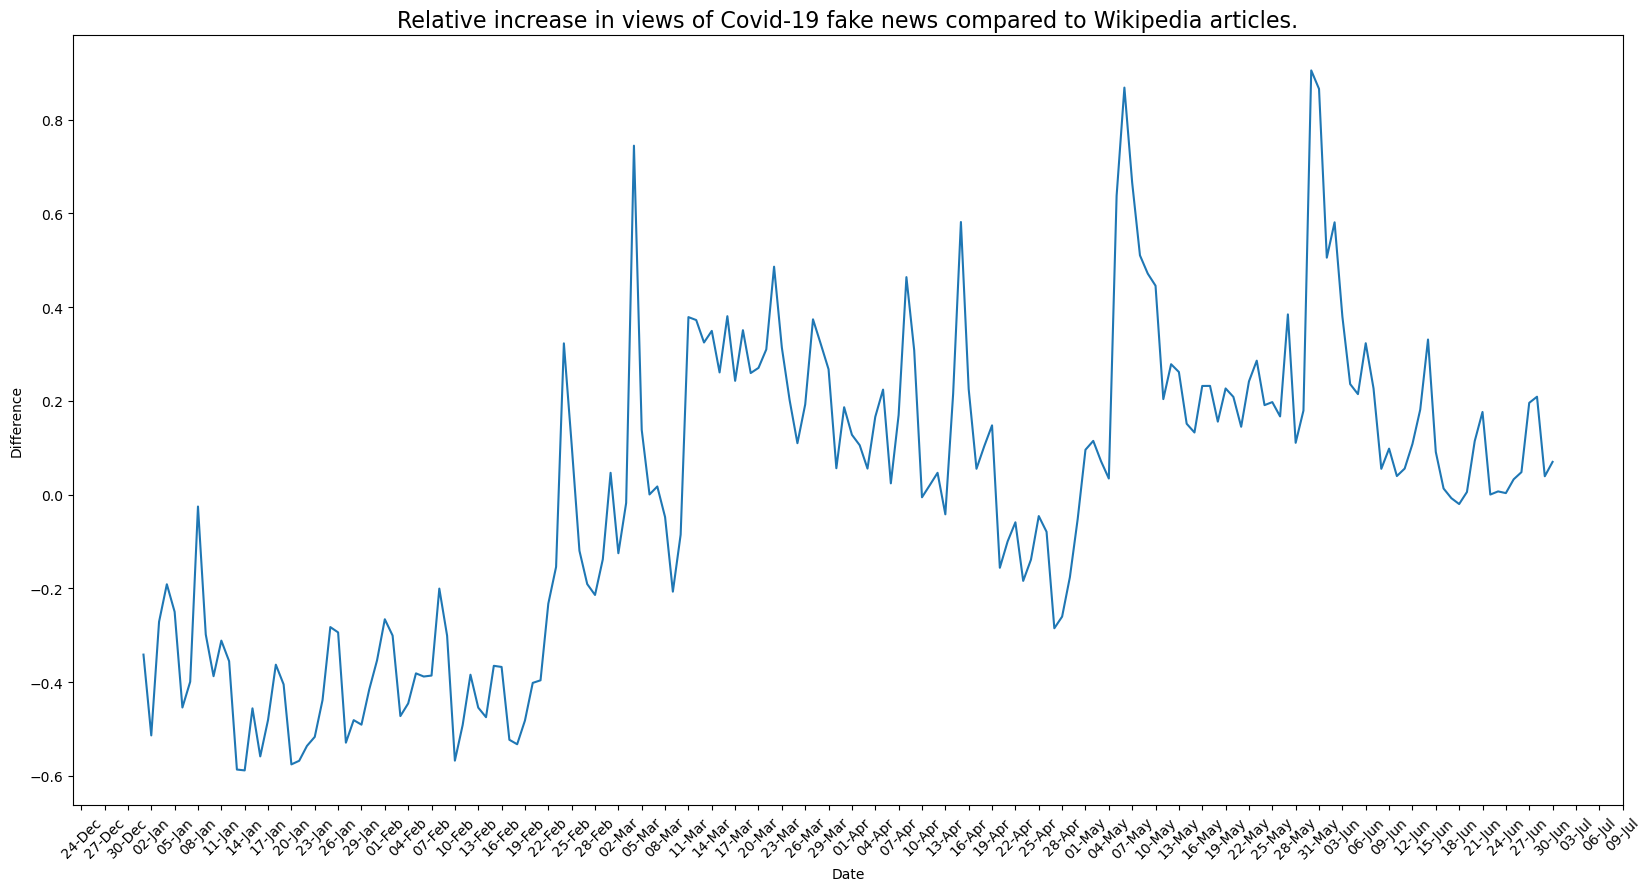

In [135]:
#concatenating the dataframes of each cluster

if final_count_1:
    final_views_1 = pd.concat(final_count_1, ignore_index=False)
else:
    final_views_1 = pd.DataFrame()

if final_count_2:
    final_views_2 = pd.concat(final_count_2, ignore_index=False)
else:
    final_views_2 = pd.DataFrame()

if final_count_3:
    final_views_3 = pd.concat(final_count_3, ignore_index=False)
else:
    final_views_3 = pd.DataFrame()

if final_count_4:
    final_views_4 = pd.concat(final_count_4, ignore_index=False)
else:
    final_views_4 = pd.DataFrame()

if final_count_5:
    final_views_5 = pd.concat(final_count_5, ignore_index=False)
else:
    final_views_5 = pd.DataFrame()

# Grouping the new data frame to get the final number of visits
data_1 = final_views_1.groupby(['timestamp']).sum()
data_2 = final_views_2.groupby(['timestamp']).sum()
#data_3 = final_views_3.groupby(['timestamp']).sum()
#data_4 = final_views_4.groupby(['timestamp']).sum()
data_5 = final_views_5.groupby(['timestamp']).sum()

df = pd.DataFrame()
df['views'] = data_1['views'] + data_2['views'] + data_5['views']
df_covid = df.copy()
df_covid.tail()

# Normalize Covid fake news
mean = df_covid['views'].mean()
df_covid_normalized = (df_covid['views'] - mean) / mean

# Create a new dataframe with columns 'date' and 'norm'
df_normalized = pd.DataFrame({'date': df_covid.index, 'norm': df_covid_normalized})

#plot the percentage of increase interest in Covid-19 fake news relative to wikipedia baseline
df_diff_covid = pd.DataFrame({'date': df_wiki_norm.reset_index()['date'], 'sum_diff': df_normalized.reset_index()['norm'] - df_wiki_norm.reset_index()['norm']})

# Plot the difference
plt.figure(figsize=(20,10))
plt.plot(df_diff_covid['date'], df_diff_covid['sum_diff'])
plt.title('Relative increase in views of Covid-19 fake news compared to Wikipedia articles.',fontsize=16)
plt.xlabel('Date')
plt.ylabel('Difference')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.show()




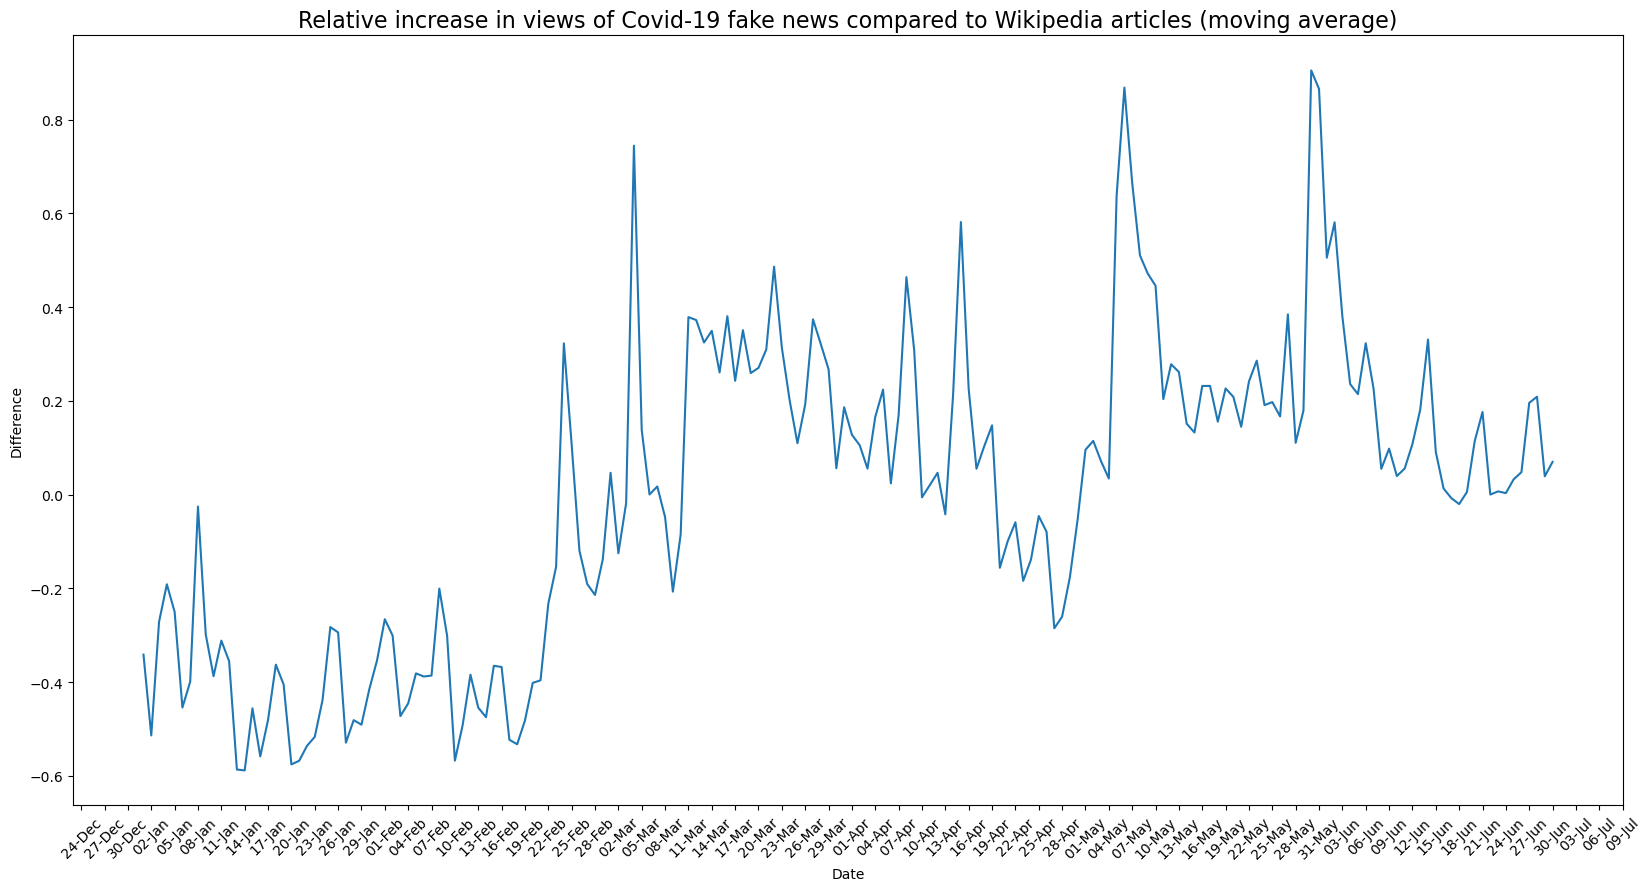

In [133]:
df_diff_covid = pd.DataFrame({'date': df_wiki_norm.reset_index()['date'], 'sum_diff': df_normalized.reset_index()['norm'] - df_wiki_norm.reset_index()['norm']})

# Plot the difference
plt.figure(figsize=(20,10))
plt.plot(df_diff_covid['date'], df_diff_covid['sum_diff'])
plt.title('Relative increase in views of Covid-19 fake news compared to Wikipedia articles (moving average)',fontsize=16)
plt.xlabel('Date')
plt.ylabel('Difference')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.show()

### We do D&D another time to see how big is the increase and if it is significant.

In [134]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas import Timedelta 
import seaborn as sns
import matplotlib.pyplot as plt


start_date = treatment_start_date - pd.Timedelta(days=65)  # 65 days before the beginning of lockdown
treatment_start_date  #beggining of lockdown 2020-03-16
treatment_end_date # Back to normal 2020-05-21

# control group data from 65 days before the beginning of lockdown to the beginning of lockdown
df_control_covid = df_diff_covid[(df_diff_covid['date'] <= treatment_start_date) & (df_diff_covid['date'] >= start_date)]
df_control_covid.reset_index(drop=True, inplace=True)

# treatment group data from the beginning of lockdown to the end of lockdown
df_treatment_covid = df_diff_covid[(df_diff_covid['date'] >= treatment_start_date) & (df_diff_covid['date'] <= treatment_end_date)]
df_treatment_covid.reset_index(drop=True, inplace=True)

# Add treatment and post-treatment columns
df_treatment_covid['treatment'] = 1
df_control_covid['treatment'] = 0

df_concatenated = pd.concat([df_control_covid, df_treatment_covid], ignore_index=True)

# Fit the model
model = smf.ols(formula='sum_diff ~ treatment', data=df_concatenated).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               sum_diff   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     85.78
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           5.15e-16
Time:                        17:03:15   Log-Likelihood:                -10.660
No. Observations:                 133   AIC:                             25.32
Df Residuals:                     131   BIC:                             31.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2463      0.033     -7.575      0.0

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4856\1777737910.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treatment_covid['treatment'] = 1
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4856\1777737910.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control_covid['treatment'] = 0


### With an R-squared of 0.396, a P-value <0.05. We consider that their is a significant increase in interest of fake news and that their around a 40% increasee.

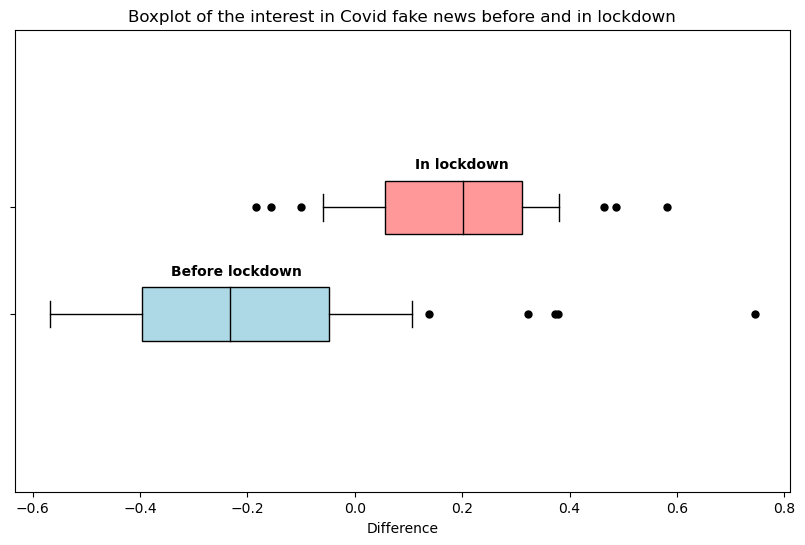

In [77]:


import chart_studio.plotly as py
import plotly.express as px

# Combine the control and treatment dataframes
df_combined = pd.concat([df_control_covid, df_treatment_covid])

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the boxplots with smaller vertical distance
boxprops = dict(facecolor='black', color='black', edgecolor='black')  # Added edgecolor to set the border color
whiskerprops = dict(color='black')  # Changed whisker color to red
capprops = dict(color='black')  # Changed cap color to red
flierprops = dict(marker='o', markerfacecolor='black', markersize=5, markeredgecolor='black')  # Added markeredgecolor for fliers
medianprops = dict(color='black')

# Specify the positions of the boxes along the y-axis
positions = [0, 0.3]

bp = ax.boxplot([df_control_covid['sum_diff'], df_treatment_covid['sum_diff']], 
                vert=False, patch_artist=True, 
                boxprops=boxprops, whiskerprops=whiskerprops, 
                capprops=capprops, flierprops=flierprops, 
                medianprops=medianprops, whis=0.5,
                positions=positions)  # Adjust the positions parameter here

# Set the y-axis ticks and labels
ax.set_yticks(positions)
ax.set_yticklabels([])  # Remove y-axis labels

# Set the title and labels
ax.set_title('Boxplot of the interest in Covid fake news before and in lockdown')
ax.set_xlabel('Difference')

# Set the colors of the boxplots


# Save the boxplot as an HTML file
#fig.savefig('1_1.html')
colors = ['lightblue', '#FF9999']  # Replace 'lightred' with '#FF9999' for light red color
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)


# Add labels above the boxplots
ax.text(-0.22, 0.12, 'Before lockdown', ha='center', va='center', color='black', fontweight='bold')
ax.text(0.2, 0.42, 'In lockdown', ha='center', va='center', color='black', fontweight='bold')

#!pip install chart-studio
# Show the plot
#plt.show()

#bp.to_html(full_html=True)
#bp.write_html("1_1.html")

plt.show()


The boxplot visualy confirms that their is a big increase in Covid-19 fake news interest (median 20% above the wikipedia article baseline and 40% greater than before the lockdown ). 